In [48]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
from scipy.sparse import load_npz
from datasketch import MinHash
from itertools import combinations
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [23]:
# create a user_movie matrix

data = np.load('../../temp_data/user_movie_rating.npy')
data_array = data.astype(int)

# Extract user, movie, and rating data from the loaded records
user_ids, movie_ids, ratings = data[:, 0], data[:, 1], data[:, 2]

# Create a CSR 
user_movie_matrix = csr_matrix((ratings, (user_ids, movie_ids)))


# Load the user-movie ratings data from the npz file
num_users = user_movie_matrix.shape[0]
num_movies = user_movie_matrix.shape[1]

In [43]:
import numpy as np
from scipy.sparse import csr_matrix

# Assuming you've already loaded the user-movie ratings data into user_movie_matrix

# Get the number of rated movies for each user
num_rated_movies_per_user = np.asarray(user_movie_matrix.sum(axis=1)).flatten()

# Define bins based on the number of movies rated
bins = {
    '1': (0, 1000),
    '2': (1001, 1500),
    '3': (1501, float('inf')),
}

# Function to bin users based on the number of movies rated
def bin_users_by_ratings(num_rated_movies_per_user):
    binned_users = {bin_name: [] for bin_name in bins}

    for user_id, num_ratings in enumerate(num_rated_movies_per_user):
        for bin_name, (lower_bound, upper_bound) in bins.items():
            if lower_bound <= num_ratings <= upper_bound:
                binned_users[bin_name].append(user_id)
                break

    return binned_users

# Bin the users
binned_users = bin_users_by_ratings(num_rated_movies_per_user)

# Print the results
for bin_name, users in binned_users.items():
    print(f'{bin_name.capitalize()} rated users ({len(users)} users): {users}')

1 rated users (1436 users): [0, 16, 29, 101, 212, 228, 268, 446, 458, 562, 601, 610, 641, 685, 703, 776, 813, 823, 854, 1148, 1149, 1224, 1280, 1291, 1316, 1435, 1440, 1465, 1564, 1707, 1764, 1770, 1869, 1933, 2077, 2171, 2187, 2344, 2502, 2592, 2633, 2647, 2680, 2720, 2835, 2857, 2931, 2963, 3084, 3101, 3122, 3202, 3228, 3243, 3260, 3440, 3443, 3457, 3542, 3623, 3686, 3697, 3758, 3998, 4031, 4170, 4182, 4390, 4409, 4464, 4542, 4589, 4746, 4778, 4788, 4938, 4940, 5064, 5075, 5100, 5103, 5135, 5168, 5284, 5358, 5367, 5385, 5407, 5532, 5534, 5605, 5609, 5670, 5757, 5770, 5827, 5840, 5940, 6007, 6132, 6137, 6381, 6582, 6635, 6702, 6773, 6934, 6977, 7113, 7198, 7363, 7393, 7410, 7424, 7454, 7537, 7540, 7643, 7648, 7660, 7661, 7786, 7889, 8038, 8120, 8177, 8245, 8255, 8309, 8492, 8575, 8600, 8676, 8705, 8811, 8822, 8843, 8883, 8951, 9061, 9266, 9294, 9326, 9332, 9416, 9515, 9633, 9662, 9710, 9754, 9852, 9865, 9870, 9879, 10164, 10340, 10411, 10459, 10476, 10576, 10611, 10671, 10775, 10807, 

Bin 1 (4817 users): [0, 16, 29, 37, 45, 61, 101, 125, 128, 150, 182, 185, 212, 214, 228, 237, 268, 270, 311, 319, 333, 446, 450, 458, 480, 490, 496, 526, 562, 590, 591, 601, 610, 631, 641, 685, 703, 711, 776, 813, 823, 828, 854, 879, 898, 938, 948, 965, 1002, 1078, 1110, 1148, 1149, 1154, 1184, 1190, 1224, 1259, 1278, 1280, 1289, 1291, 1316, 1325, 1356, 1380, 1413, 1435, 1439, 1440, 1465, 1491, 1549, 1551, 1559, 1564, 1621, 1688, 1691, 1707, 1709, 1743, 1764, 1770, 1774, 1780, 1796, 1822, 1852, 1862, 1869, 1894, 1900, 1933, 1945, 1948, 1967, 1971, 1972, 1988, 1998, 2006, 2025, 2064, 2077, 2079, 2153, 2171, 2187, 2213, 2215, 2238, 2269, 2281, 2295, 2305, 2344, 2404, 2425, 2441, 2452, 2455, 2465, 2481, 2496, 2502, 2505, 2527, 2546, 2592, 2605, 2626, 2627, 2633, 2647, 2654, 2680, 2686, 2687, 2694, 2695, 2720, 2723, 2728, 2730, 2774, 2788, 2803, 2816, 2827, 2830, 2835, 2857, 2889, 2924, 2931, 2963, 3044, 3046, 3064, 3084, 3101, 3122, 3170, 3185, 3186, 3202, 3228, 3243, 3244, 3260, 3284, 33

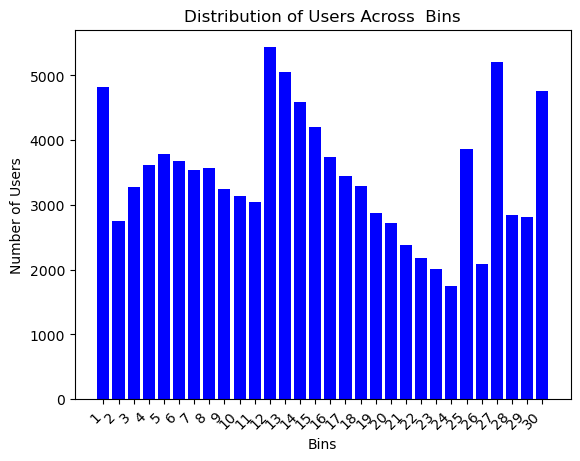

In [144]:
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

# Assuming you've already loaded the user-movie ratings data into user_movie_matrix

# Get the number of rated movies for each user
num_rated_movies_per_user = np.asarray(user_movie_matrix.sum(axis=1)).flatten()

# Define 30 custom bins based on the number of movies rated
bins = {
    '1': (0, 1100),
    '2': (1101, 1150),
    '3': (1151, 1200),
    '4': (1200, 1250),
    '5': (1251, 1300),
    '6': (1300, 1350),
    '7': (1351, 1400),
    '8': (1401, 1450),
    '9': (1451, 1500),
    '10': (1501, 1550),
    '11': (1551, 1600),
    '12': (1601, 1700),
    '13': (1701, 1800),
    '14': (1801, 1900),
    '15': (1901, 2000),
    '16': (2001, 2100),
    '17': (2101, 2200),
    '18': (2201, 2300),
    '19': (2301, 2400),
    '20': (2401, 2500),
    '21': (2501, 2600),
    '22': (2601, 2700),
    '23': (2701, 2800),
    '24': (2801, 2900),
    '25': (2901, 3150),
    '26': (3151, 3300),
    '27': (3301, 3800),
    '28': (3801, 4200),
    '29': (4201, 4800),
    '30': (4801, float('inf')),
}

# Function to bin users based on the number of movies rated
def bin_users_by_ratings(num_rated_movies_per_user):
    binned_users = {bin_name: [] for bin_name in bins}

    for user_id, num_ratings in enumerate(num_rated_movies_per_user):
        for bin_name, (lower_bound, upper_bound) in bins.items():
            if lower_bound <= num_ratings <= upper_bound:
                binned_users[bin_name].append(user_id)
                break

    return binned_users

# Bin the users
binned_users = bin_users_by_ratings(num_rated_movies_per_user)

# Print the results
total_users = sum(len(users) for users in binned_users.values())

for bin_name, users in binned_users.items():
    print(f'Bin {bin_name} ({len(users)} users): {users}')

print(f'Total Users: {total_users}')


# Plotting the histogram
bin_names = list(binned_users.keys())
user_counts = [len(users) for users in binned_users.values()]

plt.bar(bin_names, user_counts, color='blue')
plt.xlabel('Bins')
plt.ylabel('Number of Users')
plt.title('Distribution of Users Across  Bins')
plt.xticks(rotation=45, ha='right')  
plt.show()


# Minhashing FOR JS

In [148]:
user_movie_matrix_csr = user_movie_matrix.tocsr()

# Create a dictionary where keys are user IDs and values are sets of movie IDs they have rated
user_sets = {user_id: set(user_movie_matrix_csr[user_id].nonzero()[1]) for user_id in range(user_movie_matrix_csr.shape[0])}


In [149]:
# Function to perform Minhashing for Jaccard Similarity
def minhash_signature(user_set, num_hash_functions):
    signature = np.inf * np.ones(num_hash_functions, dtype=int)

    hash_functions = [(a, b) for a, b in zip(np.random.randint(1, 1000, num_hash_functions),
                                             np.random.randint(1, 1000, num_hash_functions))]

    for movie_id in user_set:
        hash_values = [(a * movie_id + b) % 1000 for a, b in hash_functions]
        signature = np.minimum(signature, hash_values)

    return signature

# Set the number of hash functions for Minhashing
num_hash_functions = 100

# Dictionary to store Minhash signatures for each user in each bin
minhash_signatures = {bin_name: {user_id: minhash_signature(user_sets[user_id], num_hash_functions)
                                 for user_id in users}
                      for bin_name, users in binned_users.items()}

# Example: Print Minhash signatures for the first user in the first bin
print(f'Minhash Signature for Bin 1, User 0: {minhash_signatures["1"][0]}')

KeyboardInterrupt: 